# Quantum boundaries of a Bell expression

## Preliminaries

In [1]:
import numpy as np
import ncpol2sdpa as ncp
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed
import json

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text rendering
    "font.family": "serif",            # Use serif font (Computer Modern)
    "font.serif": ["Computer Modern"], # Explicitly use CM serif
    "axes.labelsize": 14,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

## Functions

In [3]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

ops = ncp.flatten([A,B])        # Base monomials involved in problem
subs = {}

# 1. Unitarity: A^2 = 1
for op in ops:
    subs[op**2] = 1

# 2. Commutation: force a canonical ordering B*A → A*B
for Ai in ncp.flatten(A):
    for Bj in ncp.flatten(B):
        subs[Bj * Ai] = Ai * Bj

In [4]:
def plot_local_boundary(Theta_val, local_vertices_data, tolerance=1e-4,
                        ax=None, show_plot=None, savepath=None):
    """
    Plot local boundary. Optionally display or save the plot as a PDF.

    Parameters:
    - Theta_val: The value of theta.
    - local_vertices_data: List of (theta, vertices) pairs.
    - tolerance: Tolerance for theta matching.
    - ax: Optional matplotlib axis to plot into.
    - show_plot: If True, display the plot.
    - savepath: If given, save the figure to this path (e.g., "plot.pdf").
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract local polytope vertices for the given Theta
    local_verts = None
    for theta_value, verts in local_vertices_data:
        if abs(theta_value - Theta_val) < tolerance:
            local_verts = np.array(verts)
            break

    if local_verts is None:
        raise ValueError(f"No local polytope found for Theta = {Theta_val}")

    # Compute centroid and sort vertices
    centroid = np.mean(local_verts, axis=0)
    local_angles = np.arctan2(local_verts[:, 1] - centroid[1],
                              local_verts[:, 0] - centroid[0])
    local_verts = local_verts[np.argsort(local_angles)]
    local_verts = np.vstack([local_verts, local_verts[0]])

    # Determine if we should create a new figure
    create_figure = ax is None
    if create_figure:
        fig, ax = plt.subplots(figsize=(7, 7))

    # Plot
    ax.plot(local_verts[:, 0], local_verts[:, 1], 'ro--', lw=1.5,
            label=fr"Local polytope ($\theta = {Theta_val:.3f}$)")
    ax.set_xlabel(r"$r_0$", fontsize=12)
    ax.set_ylabel(r"$r_1$", fontsize=12)
    ax.set_title(fr"$\theta = {Theta_val:.3f}$", fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.axis("equal")
    # ax.legend(fontsize=10)

    # Save to PDF if requested
    if savepath is not None:
        plt.savefig(savepath, format='pdf', bbox_inches='tight')
        print(f"Plot saved to: {savepath}")

    # Show the plot if appropriate
    if show_plot is True or (show_plot is None and create_figure):
        plt.show()

    # Return useful data
    return {
        'theta': Theta_val,
        'local_vertices': local_verts,
        'centroid': centroid,
        'ax': ax
    }

In [46]:
def compute_quantum_vs_local_boundary(Theta_val, LEVEL, local_vertices_data, tolerance=1e-4, num_points=200, n_jobs=-1, ax=None, show_plot=None):
    """
    Compute and plot quantum vs local boundary.
    
    Parameters:
    -----------
    Theta_val : float
        The theta value for computation
    LEVEL : int or str
        The level for extra monomials
    local_vertices_data : list
        List of (theta_value, vertices) tuples
    tolerance : float, default=1e-4
        Tolerance for theta matching
    num_points : int, default=200
        Number of points for boundary computation
    n_jobs : int, default=-1
        Number of parallel jobs
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates new figure
    show_plot : bool, optional
        Whether to show the plot. If None, shows only when ax is None
    
    Returns:
    --------
    dict : Dictionary containing boundary data and plot info
    """
    # Extract local polytope vertices for the given Theta
    local_verts = None
    for theta_value, verts in local_vertices_data:
        if abs(theta_value - Theta_val) < tolerance:
            local_verts = np.array(verts)
            break

    if local_verts is None:
        raise ValueError(f"No local polytope found for Theta = {Theta_val}")

    # Compute centroid of local polytope
    centroid = np.mean(local_verts, axis=0)


    def get_extra_monomials(level):
        """
        Generate extra monomials for a given level string such as:
        'AA', 'BB', 'AB', 'AAB', 'ABB', 'AA+BB+AB+AAB+ABB', etc.
        """
        if level in [0, '0', None]:
            return []

        level_parts = level.split('+') if isinstance(level, str) else []
        monos = []
        Aflat = ncp.flatten(A)
        Bflat = ncp.flatten(B)

        if 'AA' in level_parts:
            for a1 in Aflat:
                for a2 in Aflat:
                    monos.append(a1 * a2)

        if 'BB' in level_parts:
            for b1 in Bflat:
                for b2 in Bflat:
                    monos.append(b1 * b2)

        if 'AB' in level_parts:
            for a in Aflat:
                for b in Bflat:
                    monos.append(a * b)

        if 'AAB' in level_parts:
            for a1 in Aflat:
                for a2 in Aflat:
                    for b in Bflat:
                        monos.append(a1 * a2 * b)

        if 'ABB' in level_parts:
            for a in Aflat:
                for b1 in Bflat:
                    for b2 in Bflat:
                        monos.append(a * b1 * b2)

        return monos[:]

    moment_ineqs = []
    moment_eqs = []
    op_eqs = []
    op_ineqs = []
    extra_monos = get_extra_monomials(LEVEL)

    def compute_beta(r0, r1, Theta):
        s = np.sqrt(2)
        sin_2T = np.sin(2 * Theta)
        sin_4T = np.sin(4 * Theta)
        cos_2T = np.cos(2 * Theta)
        cos_4T = np.cos(4 * Theta)
        cos_6T = np.cos(6 * Theta)

        beta_expr = (
            -1/(2*(3 - cos_4T))*0.5*r1*(-4*B[1][0]*(-3 + cos_4T) + s*(-5*cos_2T + cos_6T)*A[0][0]*B[1][0]
            + s*(-5*cos_2T + cos_6T)*A[1][0]*B[1][0] + 2*s*A[0][0]*(-3 + cos_4T)*sin_2T - 2*s*A[1][0]*(-3 + cos_4T)*sin_2T)
            - 1/(2*(3 - cos_4T))*(-4*B[0][0]*cos_2T - s*A[0][0]*B[0][0] + s*cos_4T*A[0][0]*B[0][0] - s*A[1][0]*B[0][0]
            + s*cos_4T*A[1][0]*B[0][0] - 2*s*A[0][0]*B[1][0]*sin_2T + 2*s*A[1][0]*B[1][0]*sin_2T)
            - 1/(2*(3 - cos_4T))*r0*(s*A[0][0]*(-3 + cos_4T) + s*A[1][0]*(-3 + cos_4T) - 4*B[0][0]*(-1 + cos_4T)
            + 2*s*cos_2T*A[0][0]*B[0][0] + 2*s*cos_2T*A[1][0]*B[0][0] - 2*s*cos_2T*A[0][0]*B[1][0]*sin_2T + s*A[1][0]*B[1][0]*sin_4T)
        )

        sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
        sdp.get_relaxation(
            level=0,
            equalities=op_eqs[:],
            inequalities=op_ineqs[:],
            momentequalities=moment_eqs[:],
            momentinequalities=moment_ineqs[:],
            objective=-beta_expr,
            substitutions=subs,
            extramonomials=extra_monos
        )
        sdp.solve(solver="mosek")
        return -sdp.dual

    def minimize_r(phi, Theta):
        def objective(r):
            if r < 0 or r > 1:
                return np.inf
            p1 = centroid[0] + r * np.cos(phi)
            p4 = centroid[1] + r * np.sin(phi)
            try:
                beta = compute_beta(p1, p4, Theta)
            except Exception as e:
                print(f"Exception in compute_beta at r={r}, phi={phi}, Theta={Theta}: {e}")
                return np.inf
            return r if beta >= 1.000001 else np.inf

        try:
            res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        except Exception as e:
            print(f"Exception in minimize_scalar at phi={phi}, Theta={Theta}: {e}")
            return None

        if res.success and np.isfinite(res.fun):
            r = res.x
            return centroid[0] + r * np.cos(phi), centroid[1] + r * np.sin(phi)
        else:
            return None

    def compute_boundary(Theta, num_points=200, n_jobs=-1):
        phis = np.linspace(0, np.pi, num_points)
        boundary = Parallel(n_jobs=n_jobs)(
            delayed(minimize_r)(phi, Theta) for phi in phis
        )
        boundary = [pt for pt in boundary if pt is not None]
        return np.array(boundary)

    boundary = compute_boundary(Theta_val, num_points, n_jobs)

    reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
    full_boundary = np.vstack([boundary, reflected])
    angles = np.arctan2(full_boundary[:, 1] - centroid[1], full_boundary[:, 0] - centroid[0])
    sorted_idx = np.argsort(angles)
    full_boundary = full_boundary[sorted_idx]
    full_boundary = np.vstack([full_boundary, full_boundary[0]])

    local_angles = np.arctan2(local_verts[:, 1] - centroid[1], local_verts[:, 0] - centroid[0])
    local_verts = local_verts[np.argsort(local_angles)]
    local_verts = np.vstack([local_verts, local_verts[0]])

    # Determine if we should create a new figure
    create_figure = ax is None
    if create_figure:
        fig, ax = plt.subplots(figsize=(7, 7))

    # Plot
    ax.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
    ax.plot(local_verts[:, 0], local_verts[:, 1], 'ro--', lw=1.5,
            label=fr"Local polytope ($\theta = {Theta_val:.3f}$)")
    ax.set_xlabel(r"$r_0$", fontsize=16)
    ax.set_ylabel(r"$r_1$", fontsize=16)
    ax.set_title(fr"$\theta = {Theta_val:.3f}$", fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.axis("equal")
    # ax.legend(fontsize=10)

    # Only show plot if explicitly requested or if we created a new figure
    if show_plot is True or (show_plot is None and create_figure):
        plt.show()

    # Return data for potential further use
    return {
        'theta': Theta_val,
        'quantum_boundary': full_boundary,
        'local_vertices': local_verts,
        'centroid': centroid,
        'ax': ax
    }

## Dual local boundaries

In [6]:
# Load the JSON file
with open("vertexCoords.json", "r") as f:
    data = json.load(f)

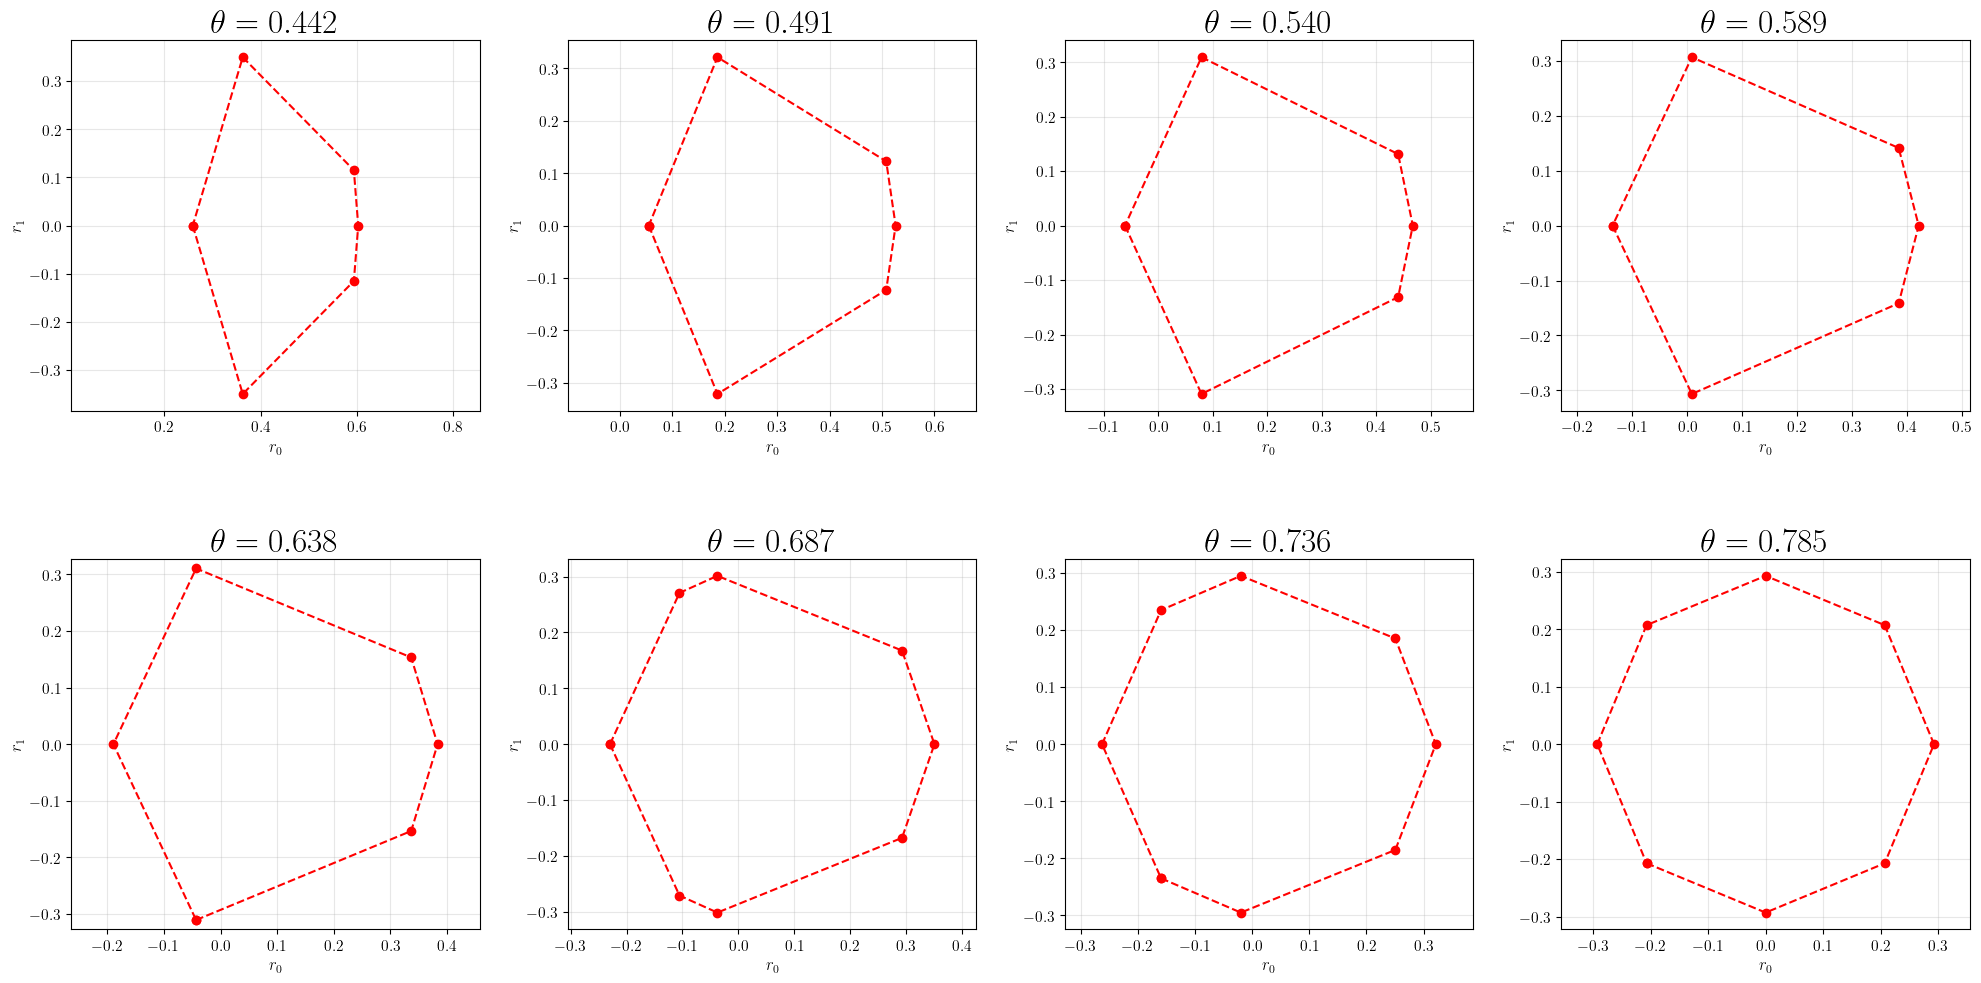

In [7]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = plot_local_boundary(
        theta, data,
        tolerance=1e-4,
        ax=ax,
        show_plot=False
        # Don't save here — it would overwrite the same file 8 times!
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("local_boundaries_grid.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B}$

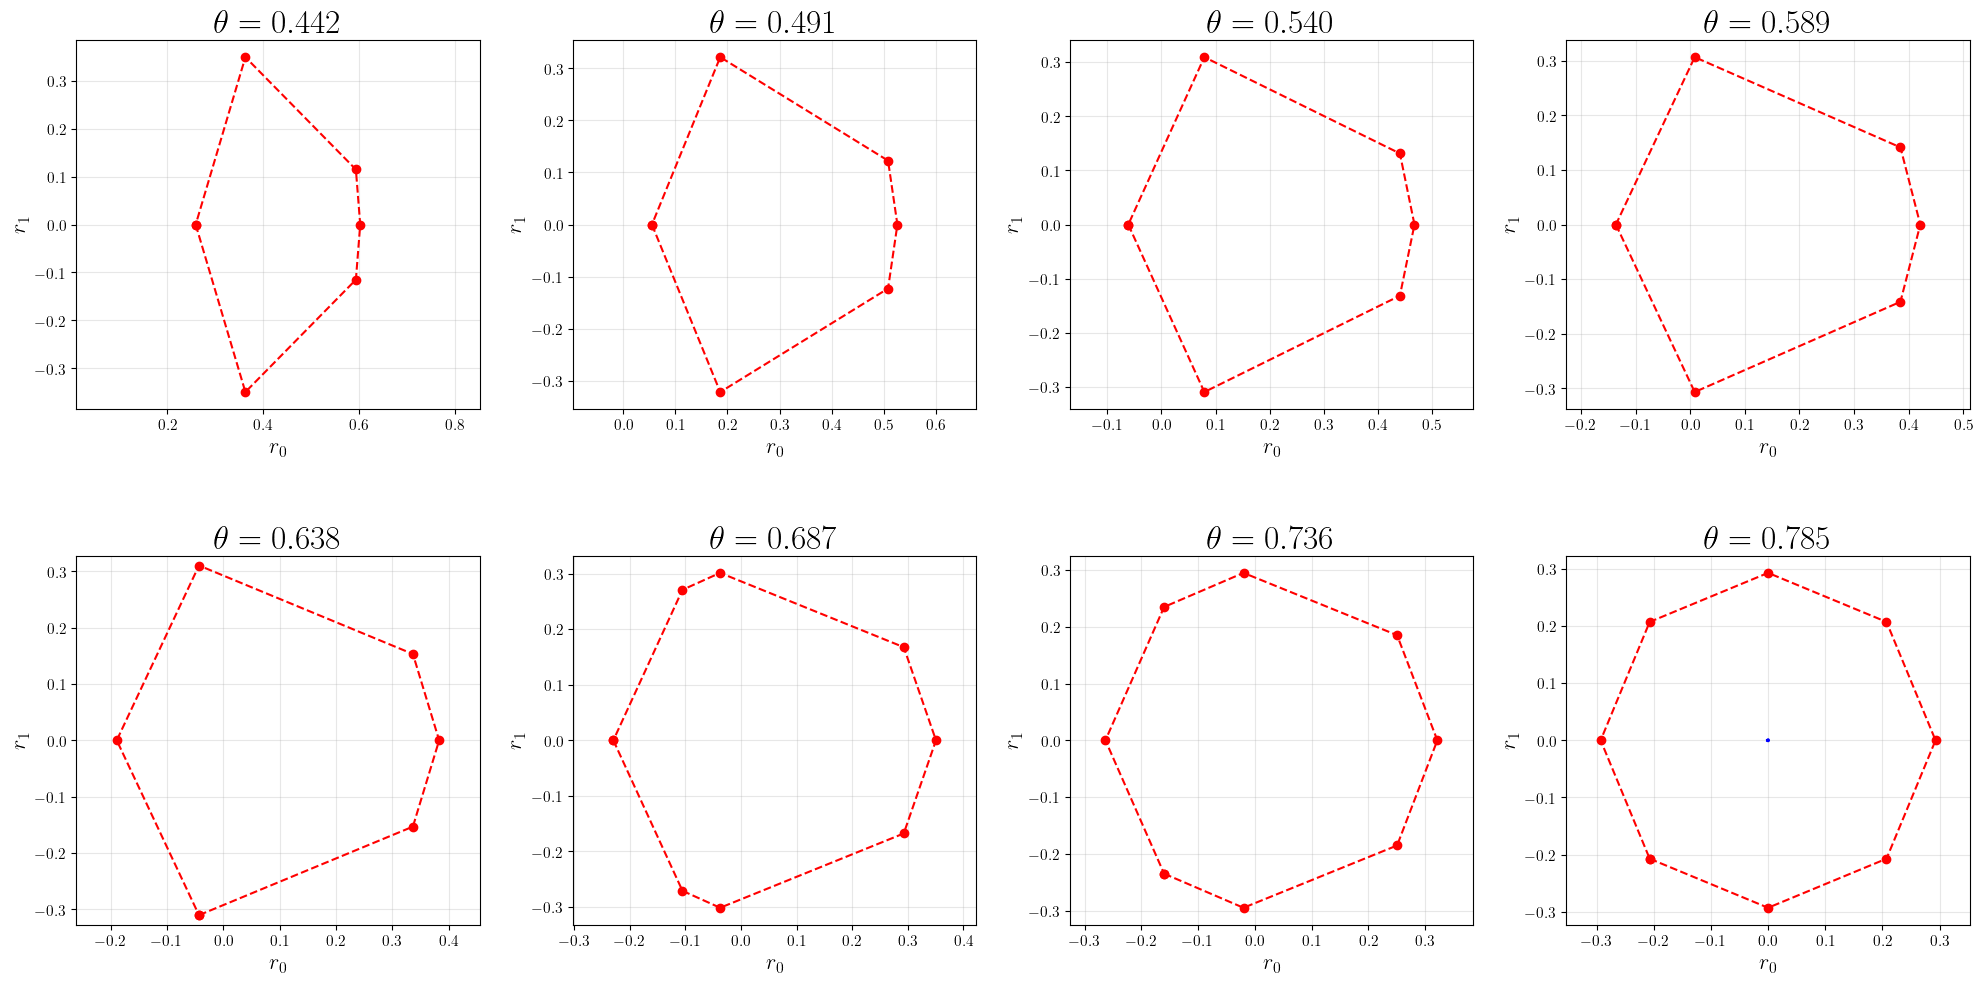

In [37]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 0, data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+AB}$

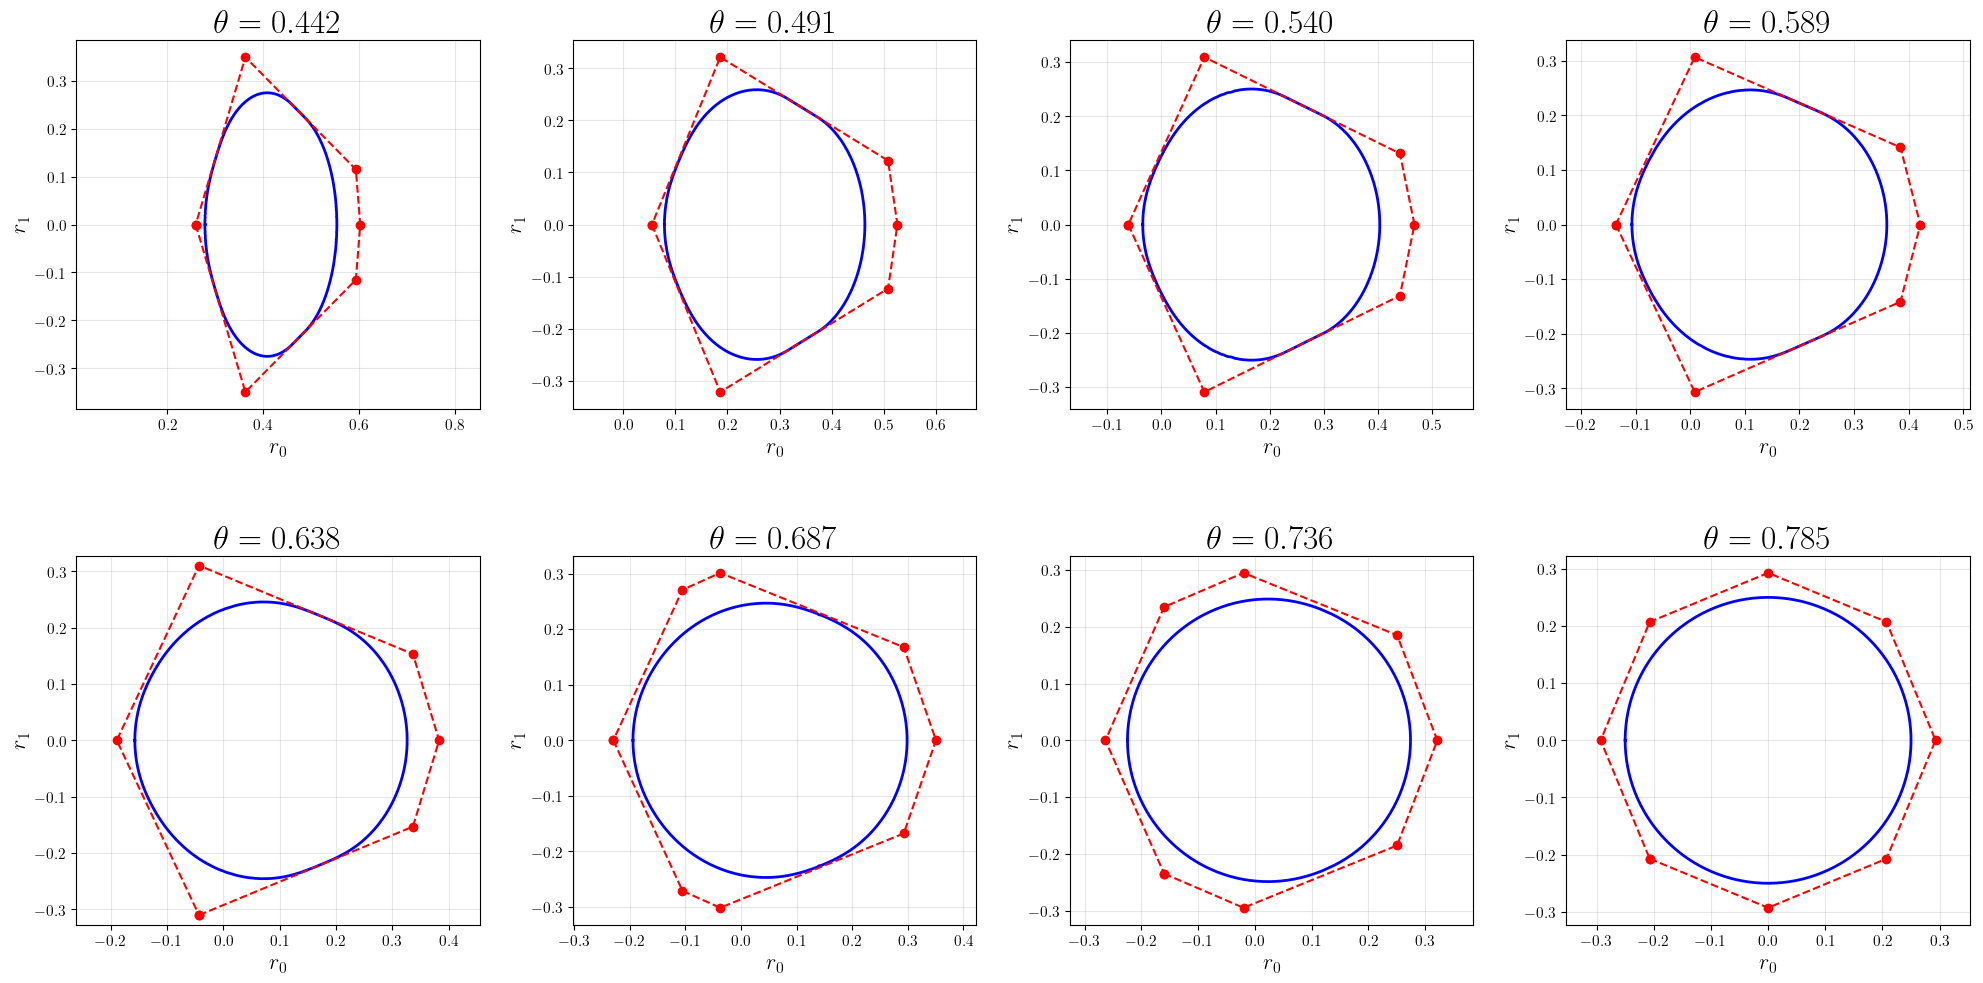

In [33]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'AB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+AB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+AA+BB+AB}$

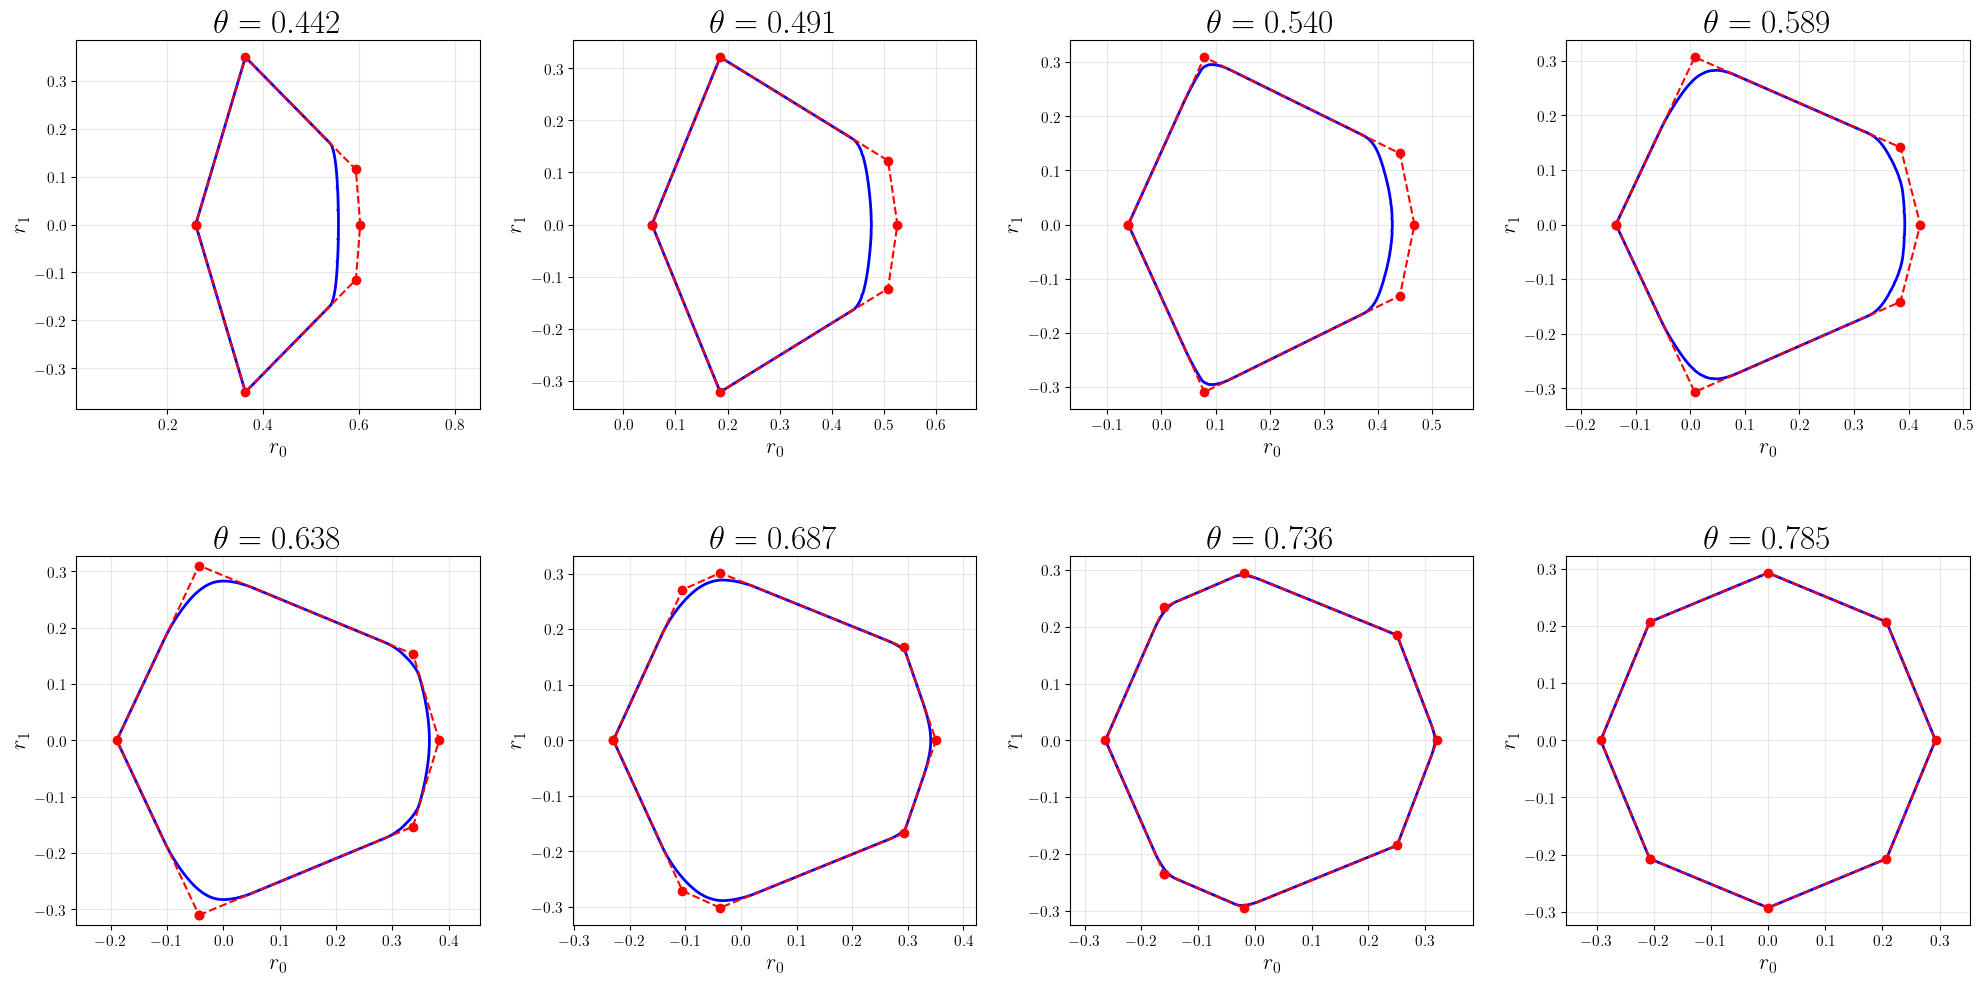

In [34]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'AA+BB+AB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+AA+BB+AB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+AB+ABB}$

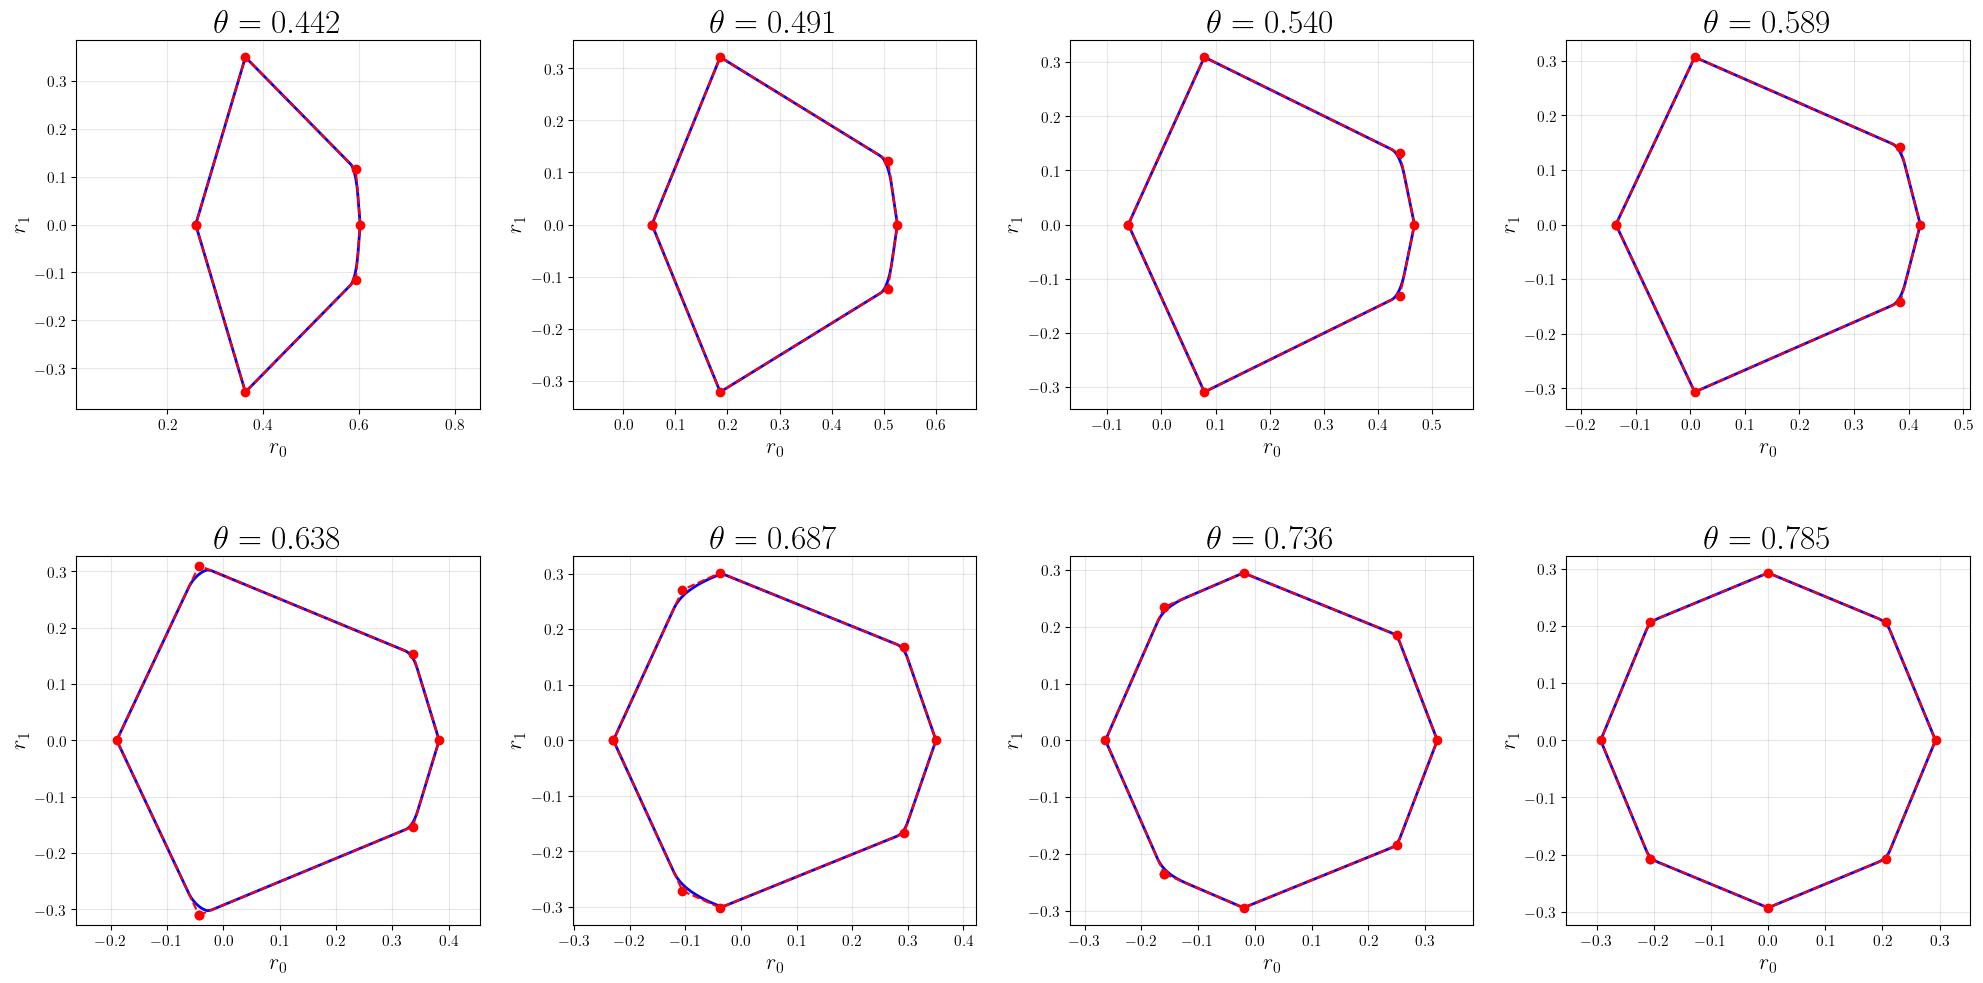

In [47]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'AB+ABB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+AB+ABB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+AB+ABB+AAB}$

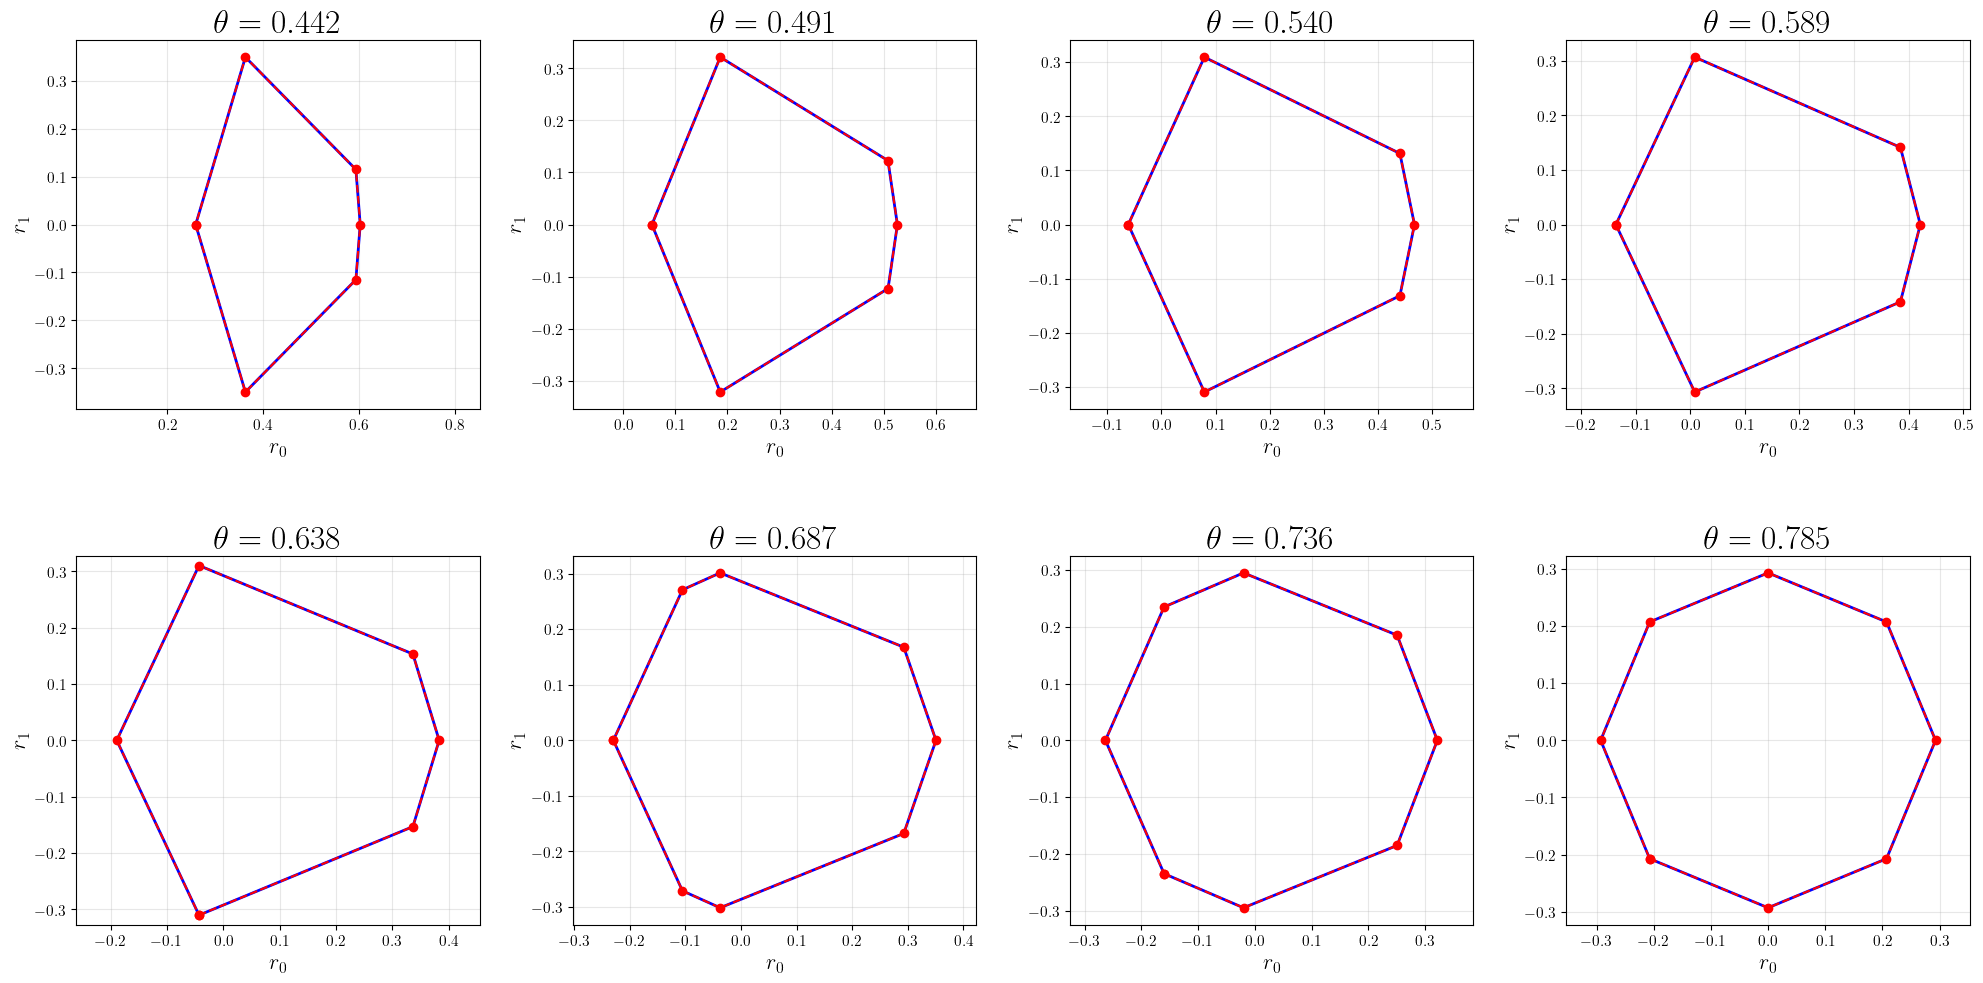

In [48]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'AB+AAB+ABB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+AB+AAB+ABB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+BB+AB+ABB}$

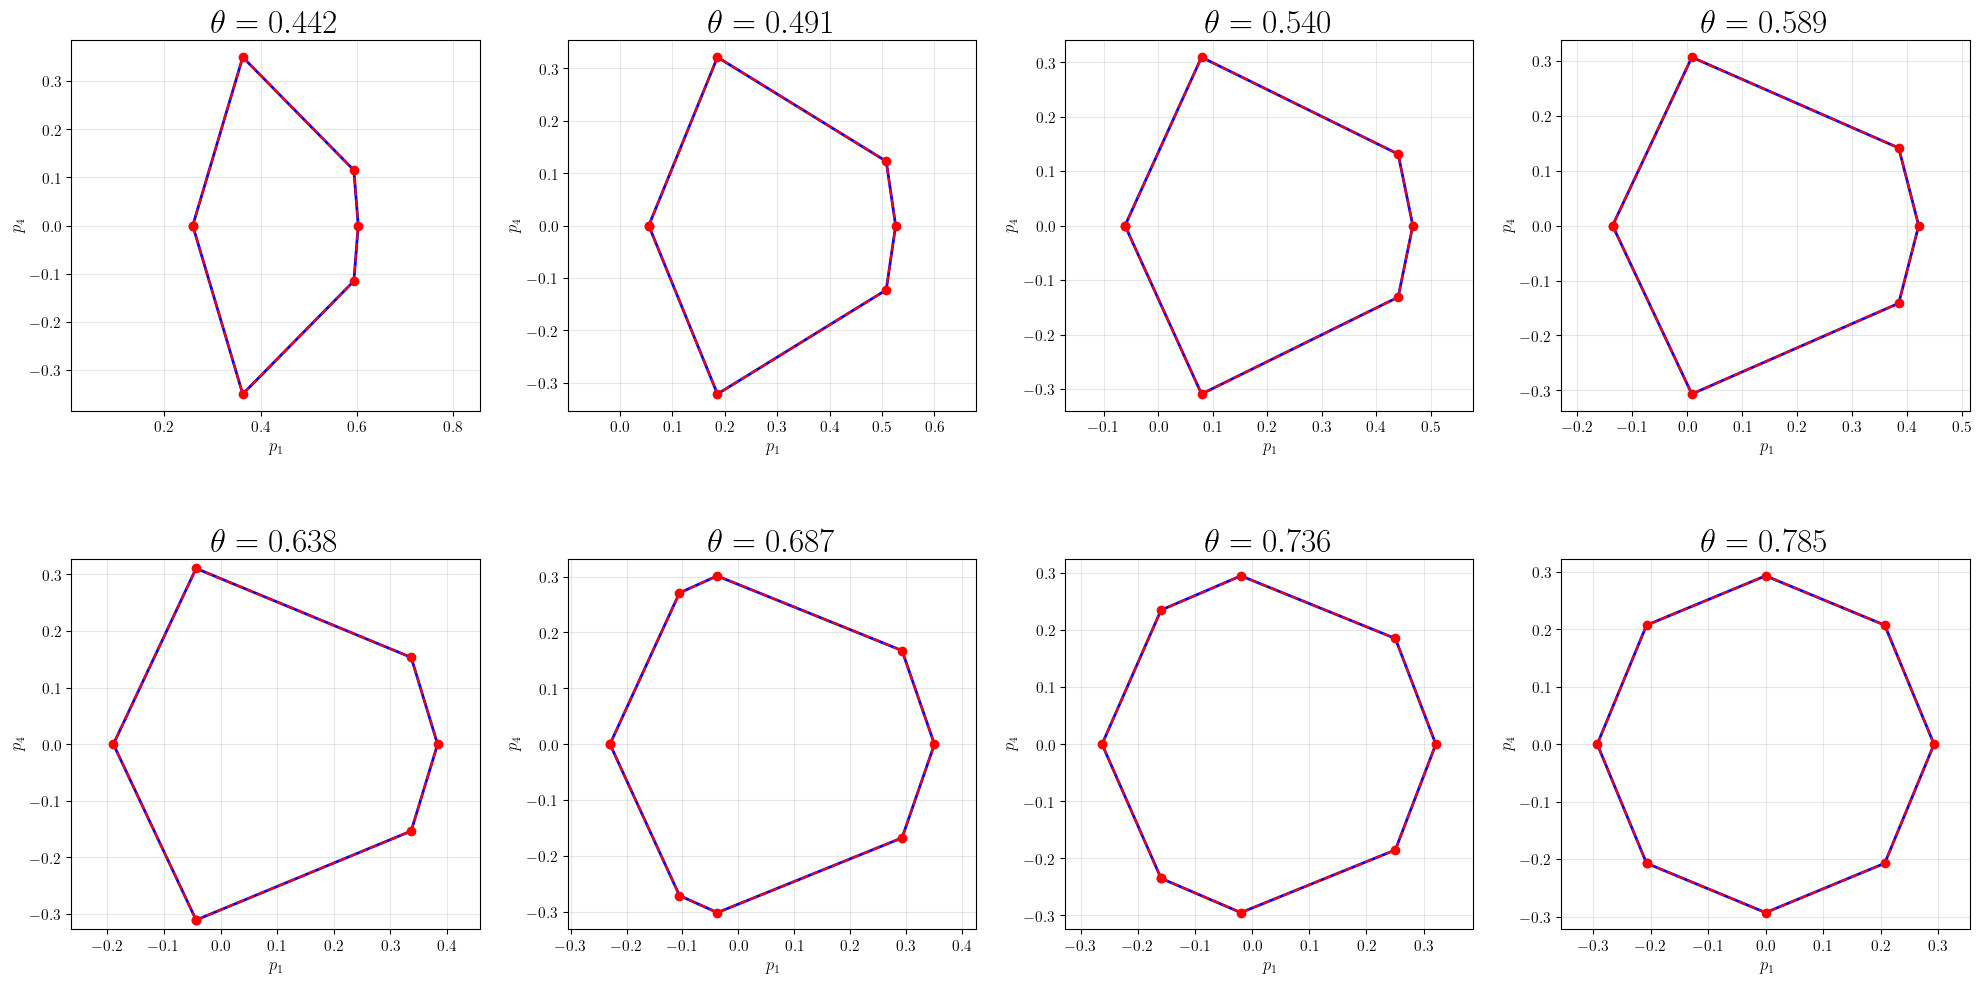

In [7]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'BB+AB+ABB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+BB+AB+ABB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## $T_{1+A+B+AA+BB+AB+ABB}$

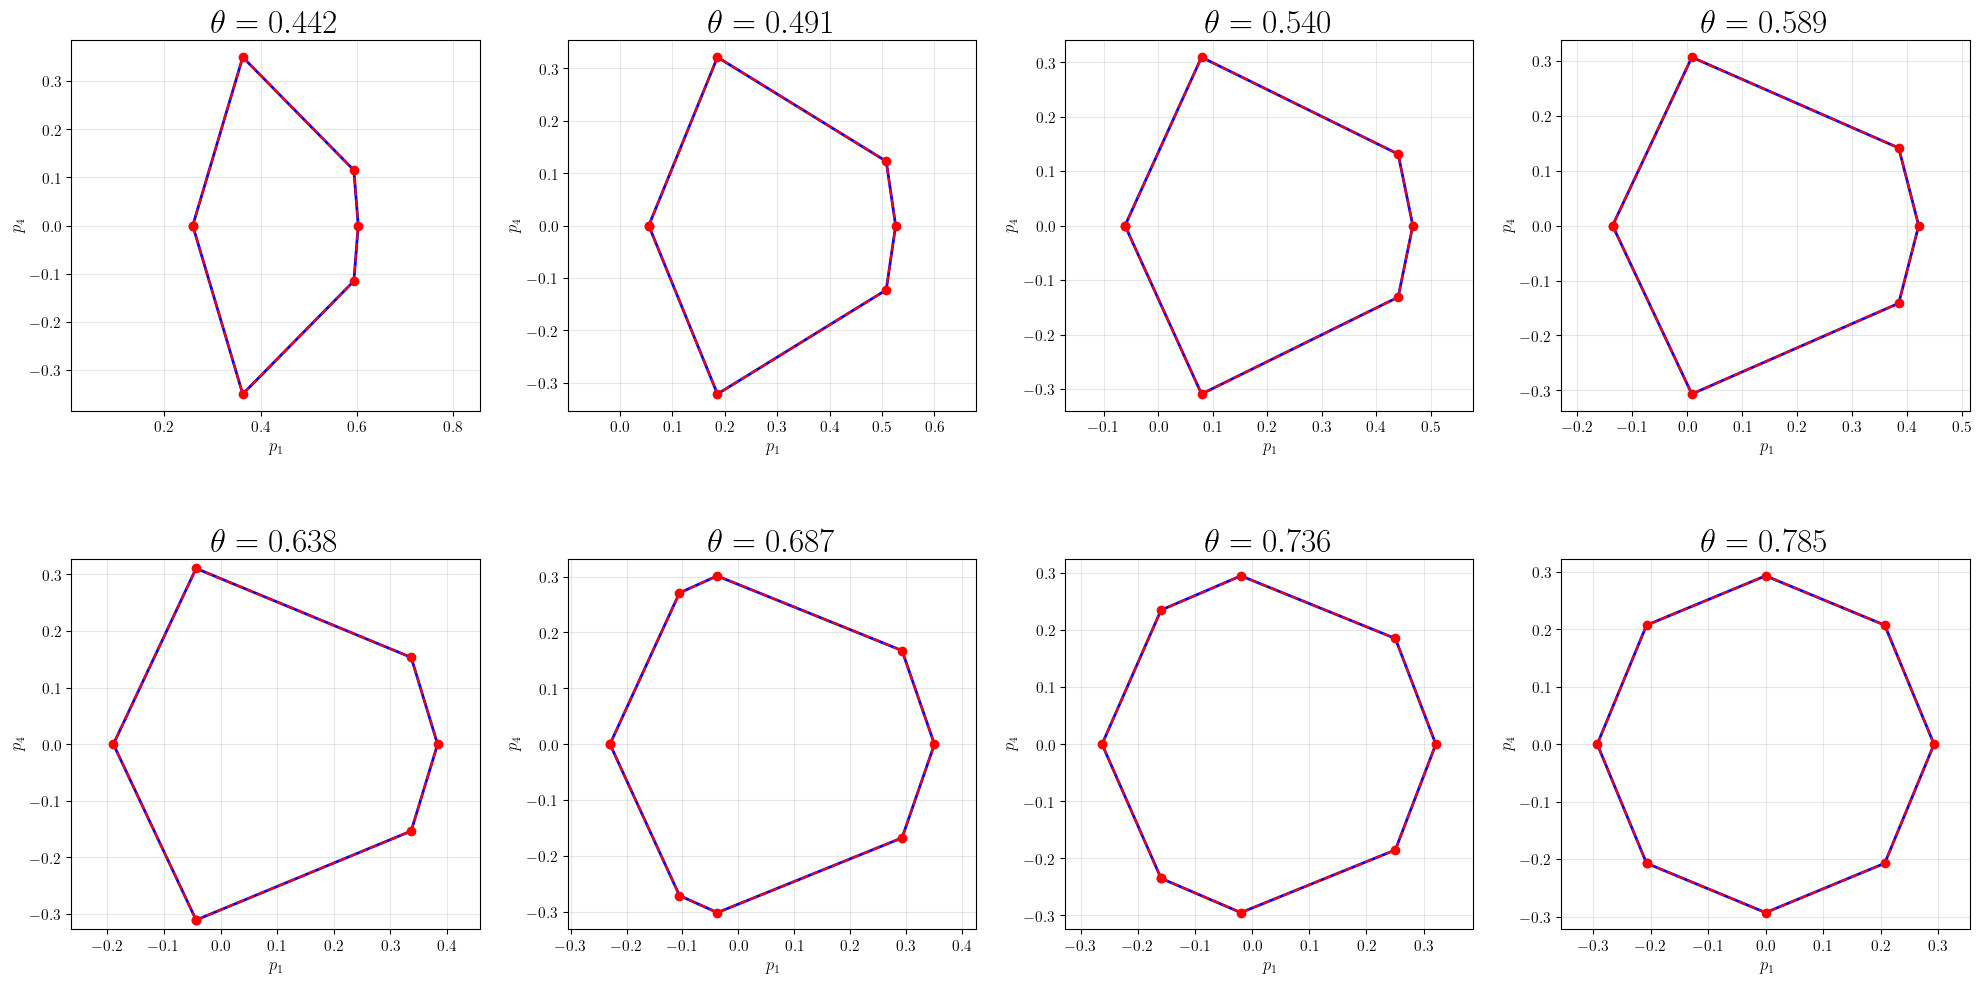

In [8]:
theta_vals = [np.pi / 8 + i * np.pi / 64 for i in range(1, 9)]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
results = []

for ax, theta in zip(axes.flat, theta_vals):
    result = compute_quantum_vs_local_boundary(
        theta, 'AA+BB+AB+ABB', data, 
        tolerance=1e-4, 
        num_points=200, 
        n_jobs=-1, 
        ax=ax, 
        show_plot=False  # Don't show individual plots
    )
    results.append(result)

plt.tight_layout()
fig.subplots_adjust(hspace=0.4)  # Fix the overlapping
plt.savefig("T_1+A+B+AA+BB+AB+ABB.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Other Plots

In [19]:
def compute_quantum_vs_local_boundary(Theta_val, LEVEL, local_vertices_data, tolerance=1e-4, num_points=200, n_jobs=-1, ax=None, show_plot=None):
    """
    Compute and plot quantum vs local boundary.
    
    Parameters:
    -----------
    Theta_val : float
        The theta value for computation
    LEVEL : int or str
        The level for extra monomials
    local_vertices_data : list
        List of (theta_value, vertices) tuples
    tolerance : float, default=1e-4
        Tolerance for theta matching
    num_points : int, default=200
        Number of points for boundary computation
    n_jobs : int, default=-1
        Number of parallel jobs
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates new figure
    show_plot : bool, optional
        Whether to show the plot. If None, shows only when ax is None
    
    Returns:
    --------
    dict : Dictionary containing boundary data and plot info
    """
    # Extract local polytope vertices for the given Theta
    local_verts = None
    for theta_value, verts in local_vertices_data:
        if abs(theta_value - Theta_val) < tolerance:
            local_verts = np.array(verts)
            break

    if local_verts is None:
        raise ValueError(f"No local polytope found for Theta = {Theta_val}")

    # Compute centroid of local polytope
    centroid = np.mean(local_verts, axis=0)

    def get_extra_monomials(level):
        """
        Generate extra monomials for a given level string such as:
        'AA', 'BB', 'AB', 'AAB', 'ABB', 'AA+BB+AB+AAB+ABB', etc.
        """
        if level in [0, '0', None]:
            return []

        level_parts = level.split('+') if isinstance(level, str) else []
        monos = []
        Aflat = ncp.flatten(A)
        Bflat = ncp.flatten(B)

        if 'AA' in level_parts:
            for a1 in Aflat:
                for a2 in Aflat:
                    monos.append(a1 * a2)

        if 'BB' in level_parts:
            for b1 in Bflat:
                for b2 in Bflat:
                    monos.append(b1 * b2)

        if 'AB' in level_parts:
            for a in Aflat:
                for b in Bflat:
                    monos.append(a * b)

        if 'AAB' in level_parts:
            for a1 in Aflat:
                for a2 in Aflat:
                    for b in Bflat:
                        monos.append(a1 * a2 * b)

        if 'ABB' in level_parts:
            for a in Aflat:
                for b1 in Bflat:
                    for b2 in Bflat:
                        monos.append(a * b1 * b2)

        return monos[:]

    moment_ineqs = []
    moment_eqs = []
    op_eqs = []
    op_ineqs = []
    extra_monos = get_extra_monomials(LEVEL)

    def compute_beta(r0, r1, Theta):
        s = np.sqrt(2)
        sin_2T = np.sin(2 * Theta)
        sin_4T = np.sin(4 * Theta)
        cos_2T = np.cos(2 * Theta)
        cos_4T = np.cos(4 * Theta)
        cos_6T = np.cos(6 * Theta)

        beta_expr = (
            -1/(2*(3 - cos_4T))*0.5*r1*(-4*B[1][0]*(-3 + cos_4T) + s*(-5*cos_2T + cos_6T)*A[0][0]*B[1][0]
            + s*(-5*cos_2T + cos_6T)*A[1][0]*B[1][0] + 2*s*A[0][0]*(-3 + cos_4T)*sin_2T - 2*s*A[1][0]*(-3 + cos_4T)*sin_2T)
            - 1/(2*(3 - cos_4T))*(-4*B[0][0]*cos_2T - s*A[0][0]*B[0][0] + s*cos_4T*A[0][0]*B[0][0] - s*A[1][0]*B[0][0]
            + s*cos_4T*A[1][0]*B[0][0] - 2*s*A[0][0]*B[1][0]*sin_2T + 2*s*A[1][0]*B[1][0]*sin_2T)
            - 1/(2*(3 - cos_4T))*r0*(s*A[0][0]*(-3 + cos_4T) + s*A[1][0]*(-3 + cos_4T) - 4*B[0][0]*(-1 + cos_4T)
            + 2*s*cos_2T*A[0][0]*B[0][0] + 2*s*cos_2T*A[1][0]*B[0][0] - 2*s*cos_2T*A[0][0]*B[1][0]*sin_2T + s*A[1][0]*B[1][0]*sin_4T)
        )

        sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
        sdp.get_relaxation(
            level=0,
            equalities=op_eqs[:],
            inequalities=op_ineqs[:],
            momentequalities=moment_eqs[:],
            momentinequalities=moment_ineqs[:],
            objective=-beta_expr,
            substitutions=subs,
            extramonomials=extra_monos
        )
        sdp.solve(solver="mosek")
        return -sdp.dual

    def minimize_r(phi, Theta):
        def objective(r):
            if r < 0 or r > 1:
                return np.inf
            p1 = centroid[0] + r * np.cos(phi)
            p4 = centroid[1] + r * np.sin(phi)
            try:
                beta = compute_beta(p1, p4, Theta)
            except Exception as e:
                print(f"Exception in compute_beta at r={r}, phi={phi}, Theta={Theta}: {e}")
                return np.inf
            return r if beta >= 1.00001 else np.inf

        try:
            res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
        except Exception as e:
            print(f"Exception in minimize_scalar at phi={phi}, Theta={Theta}: {e}")
            return None

        if res.success and np.isfinite(res.fun):
            r = res.x
            return centroid[0] + r * np.cos(phi), centroid[1] + r * np.sin(phi)
        else:
            return None

    def compute_boundary(Theta, num_points=200, n_jobs=-1):
        phis = np.linspace(0, np.pi, num_points)
        boundary = Parallel(n_jobs=n_jobs)(
            delayed(minimize_r)(phi, Theta) for phi in phis
        )
        boundary = [pt for pt in boundary if pt is not None]
        return np.array(boundary)

    boundary = compute_boundary(Theta_val, num_points, n_jobs)

    reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
    full_boundary = np.vstack([boundary, reflected])
    angles = np.arctan2(full_boundary[:, 1] - centroid[1], full_boundary[:, 0] - centroid[0])
    sorted_idx = np.argsort(angles)
    full_boundary = full_boundary[sorted_idx]
    full_boundary = np.vstack([full_boundary, full_boundary[0]])

    local_angles = np.arctan2(local_verts[:, 1] - centroid[1], local_verts[:, 0] - centroid[0])
    local_verts = local_verts[np.argsort(local_angles)]
    local_verts = np.vstack([local_verts, local_verts[0]])

    # Determine if we should create a new figure
    create_figure = ax is None
    if create_figure:
        fig, ax = plt.subplots(figsize=(7, 7))

    # Plot
    ax.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
    ax.plot(local_verts[:, 0], local_verts[:, 1], 'ro--', lw=1.5,
            label=fr"Local polytope ($\theta = {Theta_val:.3f}$)")
    ax.set_xlabel(r"$r_0$", fontsize=12)
    ax.set_ylabel(r"$r_1$", fontsize=12)
    ax.set_title(fr"$\theta = {Theta_val:.3f}$", fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.axis("equal")
    # ax.legend(fontsize=10)

    # Only show plot if explicitly requested or if we created a new figure
    if show_plot is True or (show_plot is None and create_figure):
        plt.show()

    # Return data for potential further use
    return {
        'theta': Theta_val,
        'quantum_boundary': full_boundary,
        'local_vertices': local_verts,
        'centroid': centroid,
        'ax': ax
    }

### $\theta = \pi/8 + 5\pi/64$

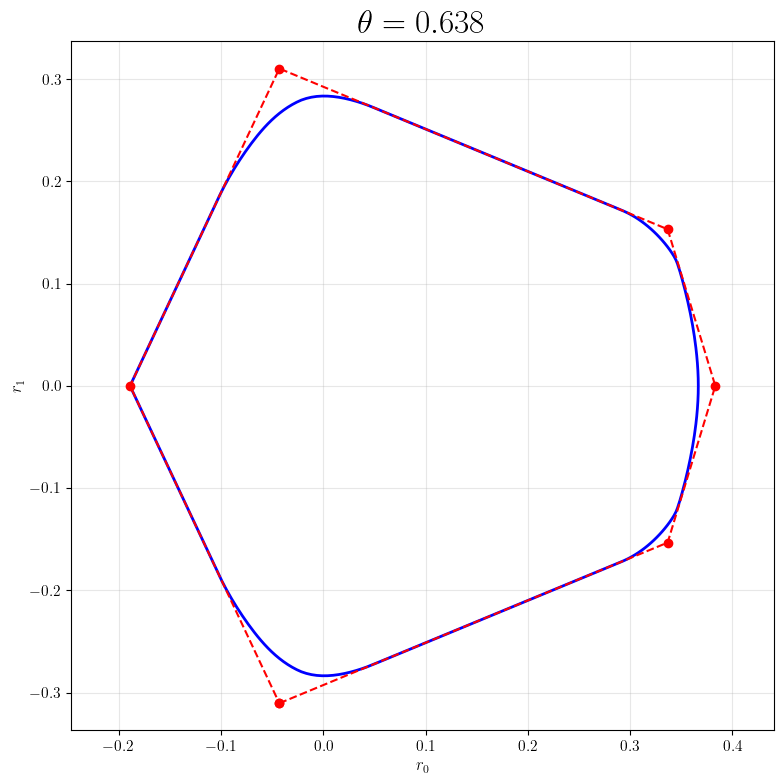

In [29]:
theta = np.pi / 8 + 5 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+AB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig5_AA+BB+AB.pdf", format="pdf")
plt.show()

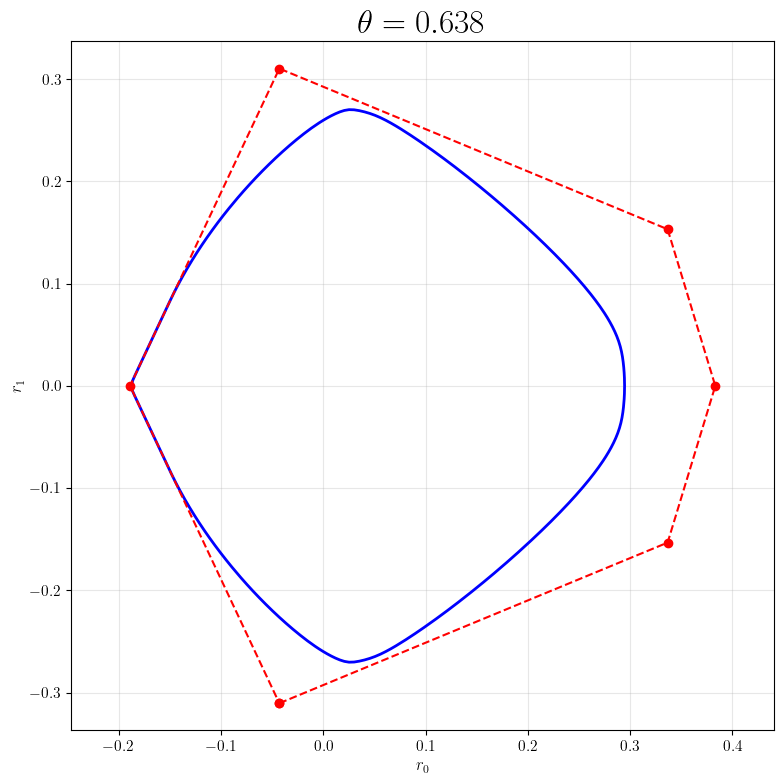

In [32]:
theta = np.pi / 8 + 5 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig5_AA+BB+ABB.pdf", format="pdf")
plt.show()

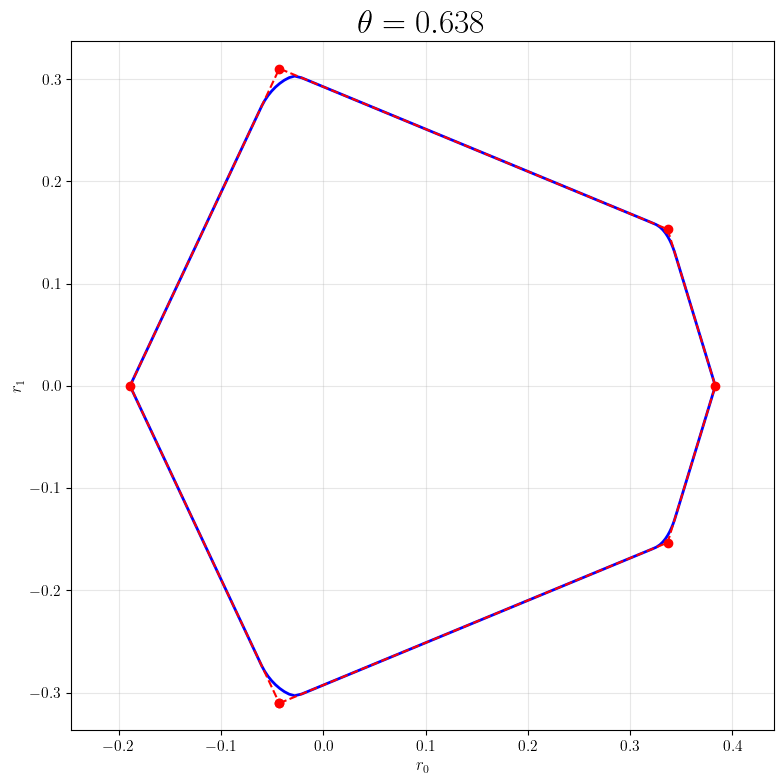

In [27]:
theta = np.pi / 8 + 5 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig5_AB+ABB.pdf", format="pdf")
plt.show()

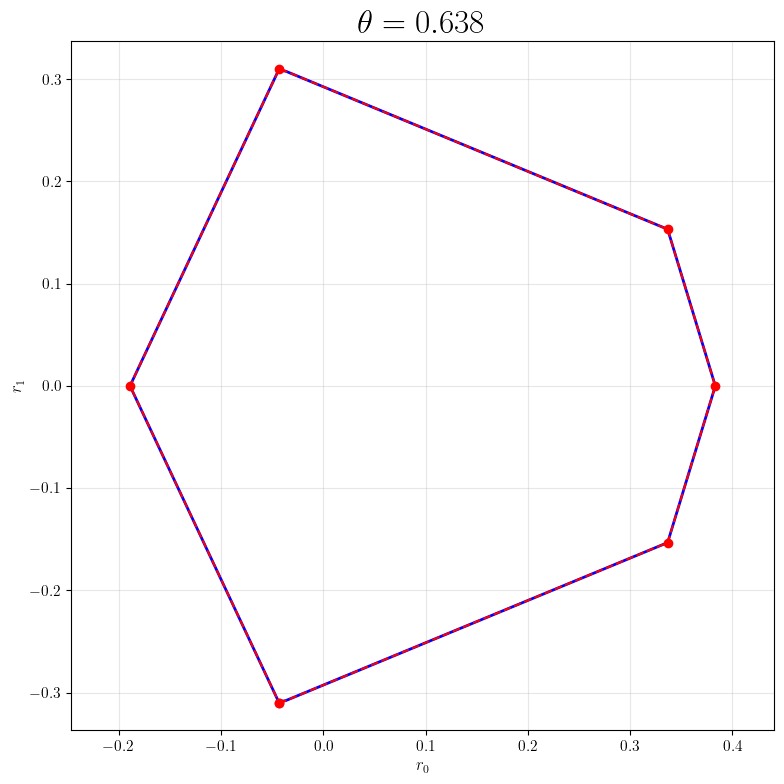

In [26]:
theta = np.pi / 8 + 5 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+AB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig5_AA+BB+AB+ABB.pdf", format="pdf")
plt.show()

### $\theta = \pi/8 + 6\pi/64$

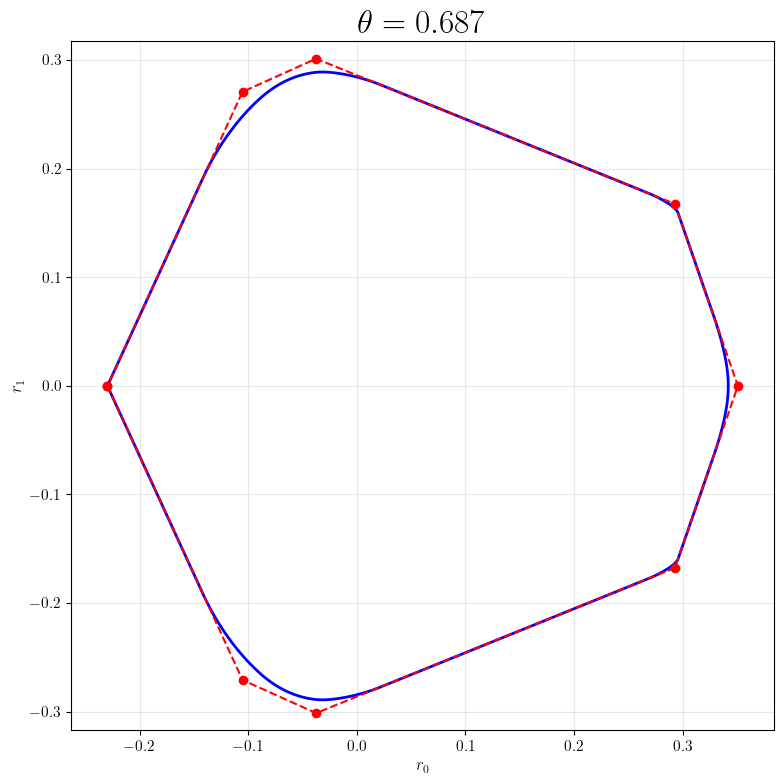

In [30]:
theta = np.pi / 8 + 6 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+AB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig6_AA+BB+AB.pdf", format="pdf")
plt.show()

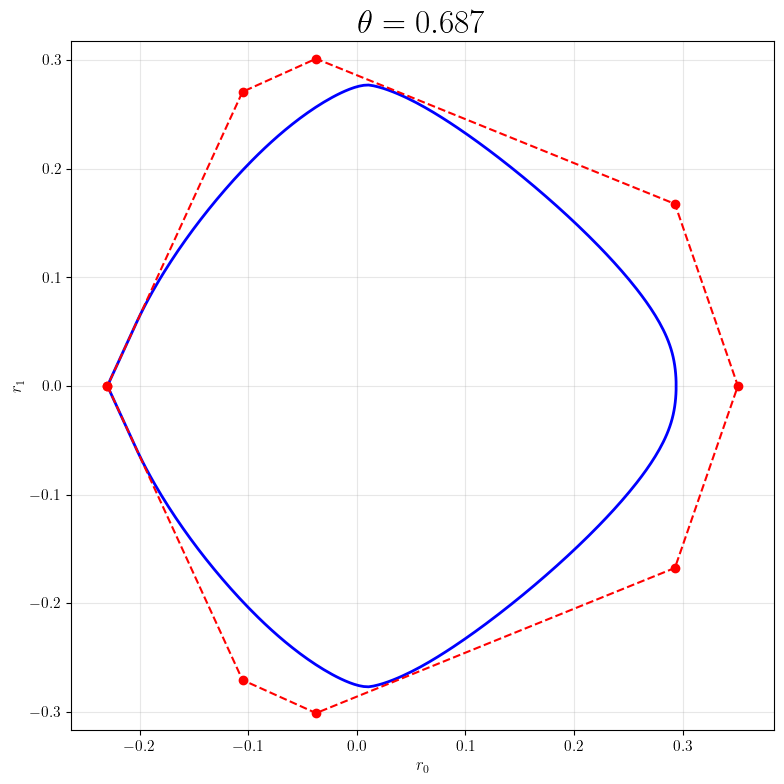

In [31]:
theta = np.pi / 8 + 6 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig6_AA+BB+ABB.pdf", format="pdf")
plt.show()

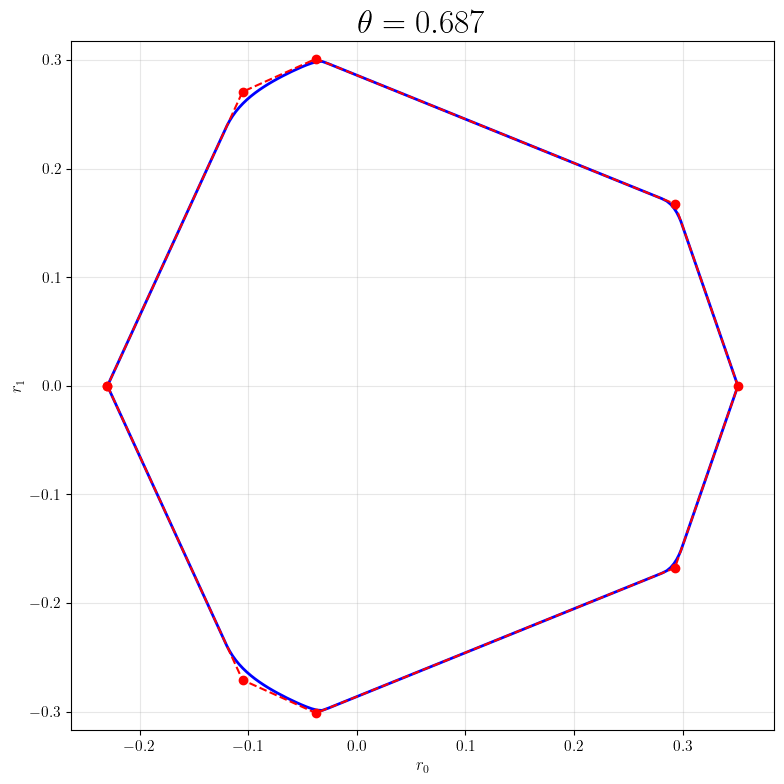

In [25]:
theta = np.pi / 8 + 6 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig6_AB+ABB.pdf", format="pdf")
plt.show()

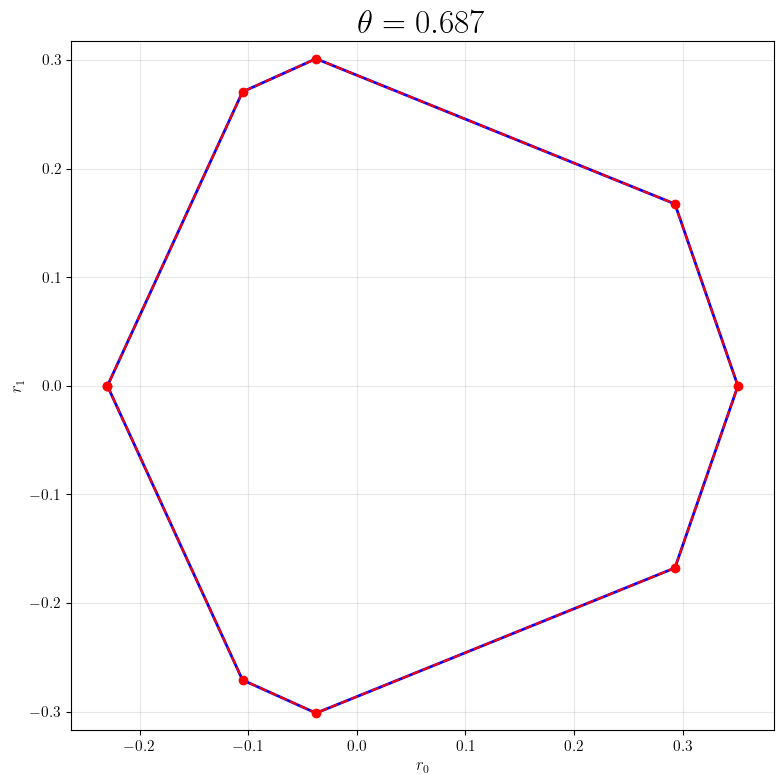

In [24]:
theta = np.pi / 8 + 6 * np.pi / 64  # Single theta value

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed

result = compute_quantum_vs_local_boundary(
    theta, 'AA+BB+AB+ABB', data,
    tolerance=1e-4,
    num_points=200,
    n_jobs=-1,
    ax=ax,
    show_plot=False
)

plt.tight_layout()
plt.savefig("fig6_AA+BB+AB+ABB.pdf", format="pdf")
plt.show()